# JWST NIRSpec MSA Observations Analysis

This notebook analyzes 8 NIRSpec MSA observations of a target star, calculating the exact MSA quadrant positions and fractional coordinates for each observation.

## Overview

Given:
- Target star coordinates: RA = 00h 36m 28.7774s, Dec = +39° 35' 26.30"
- 8 observations with different MSA pointings (RA, Dec) and APAs
- Observations 1-4: PRISM + Grating mode
- Observations 5-8: PRISM only mode

The notebook calculates for each observation:
- **Quadrant**: Which MSA quadrant (1, 2, 3, or 4) contains the target
- **x_frac, y_frac**: Fractional position within that quadrant

## Method

The calculation is the inverse of `sky_to_pointing()`:
1. Create attitude matrix for the MSA pointing and APA
2. Transform target sky coordinates to telescope (V2, V3) frame
3. For each quadrant, convert V2/V3 to Ideal coordinates
4. Check if target falls within quadrant bounds
5. Calculate fractional position: (0,0) = top-left, (1,1) = bottom-right

This is an **exact calculation** requiring no iterations.

## Required Packages
- pysiaf
- matplotlib
- numpy
- astropy
- pandas


In [1]:
# Import required packages
import sys
import numpy as np
import matplotlib.pyplot as plt

# Enable interactive plots with widget backend
%matplotlib widget

In [2]:
# Initialize the plotter
# Force reload of the module to get latest changes
if 'nirspec_fov_plotter' in sys.modules: del sys.modules['nirspec_fov_plotter']
from nirspec_fov_plotter import NIRSpecFOVPlotter, plot_nirspec_fov, calculate_msa_position

MSA_plotter = NIRSpecFOVPlotter()
print("NIRSpecFOVPlotter initialized successfully")

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


NIRSpecFOVPlotter initialized successfully


## Target Star Definition

Define the target star coordinates that will be observed in all 8 observations.


In [3]:
# Convert target star coordinates from HMS/DMS to decimal degrees
from astropy.coordinates import Angle

# Target star: M31 PN2358
target_ra_hms  =  "00:36:28.7774"
target_dec_dms = "+39:35:26.30"

target_ra  = Angle(target_ra_hms, unit='hourangle').deg
target_dec = Angle(target_dec_dms, unit='degree').deg

print(f"Target Star:")
print(f"  RA  = {target_ra_hms} = {target_ra:.6f}°")
print(f"  Dec = {target_dec_dms} = {target_dec:.6f}°")


Target Star:
  RA  = 00:36:28.7774 = 9.119906°
  Dec = +39:35:26.30 = 39.590639°


## Observations 1-8: MSA Pointing Data

Define the 8 observations with their MSA pointings (RA, Dec) and APAs.
Observations 1-4 are PRISM+Grating, and observations 5-8 are PRISM only.


In [4]:
# Extract observations 1-8 from the screenshot
# Each observation has: APA, MSA pointing RA, MSA pointing Dec

observations_1_to_8 = [
    {'id': 1, 'apa': 206.5746, 'ra_hms': '00:36:38.9652', 'dec_dms': '+39:36:01.984'},
    {'id': 2, 'apa': 206.5746, 'ra_hms': '00:36:32.9994', 'dec_dms': '+39:33:21.977'},
    {'id': 3, 'apa': 206.5746, 'ra_hms': '00:36:31.2797', 'dec_dms': '+39:37:02.474'},
    {'id': 4, 'apa': 223.0668, 'ra_hms': '00:36:26.5482', 'dec_dms': '+39:35:19.002'},
    {'id': 5, 'apa': 223.0668, 'ra_hms': '00:36:31.9340', 'dec_dms': '+39:35:31.677'},
    {'id': 6, 'apa': 216.9098, 'ra_hms': '00:36:25.8643', 'dec_dms': '+39:33:59.006'},
    {'id': 7, 'apa': 234.9153, 'ra_hms': '00:36:30.2304', 'dec_dms': '+39:37:33.542'},
    {'id': 8, 'apa': 236.9302, 'ra_hms': '00:36:18.2190', 'dec_dms': '+39:35:57.67'},
]

# Convert HMS/DMS to decimal degrees
for obs in observations_1_to_8:
    obs['msa_ra']  = Angle(obs['ra_hms'], unit='hourangle').deg
    obs['msa_dec'] = Angle(obs['dec_dms'], unit='degree').deg
    obs['type'] = 'PRISM+Grating' if obs['id'] <= 4 else 'PRISM only'
    obs['color'] = 'blue' if obs['id'] <= 4 else 'magenta'

print("Observations 1-8 (MSA Pointings):")
print("Obs | APA      | MSA RA    | MSA Dec   | Type")
print("-" * 60)
for obs in observations_1_to_8:
    print(f"{obs['id']:3d} | {obs['apa']:8.4f} | {obs['msa_ra']:9.6f} | {obs['msa_dec']:9.6f} | {obs['type']}")


Observations 1-8 (MSA Pointings):
Obs | APA      | MSA RA    | MSA Dec   | Type
------------------------------------------------------------
  1 | 206.5746 |  9.162355 | 39.600551 | PRISM+Grating
  2 | 206.5746 |  9.137497 | 39.556105 | PRISM+Grating
  3 | 206.5746 |  9.130332 | 39.617354 | PRISM+Grating
  4 | 223.0668 |  9.110617 | 39.588612 | PRISM+Grating
  5 | 223.0668 |  9.133058 | 39.592133 | PRISM only
  6 | 216.9098 |  9.107768 | 39.566391 | PRISM only
  7 | 234.9153 |  9.125960 | 39.625984 | PRISM only
  8 | 236.9302 |  9.075912 | 39.599353 | PRISM only


## Calculate MSA Quadrant Position

For each observation, calculate where the target star falls in the MSA:
- Quadrant (1, 2, 3, or 4)
- x_frac and y_frac within that quadrant
  - (0,0) = top-left
  - (1,1) = bottom-right



In [5]:
msa_obs_ra_hms  =  '00:36:38.9652'
msa_obs_dec_dms = '+39:36:01.984'
msa_obs_ra  = Angle(msa_obs_ra_hms,  unit='hourangle').deg
msa_obs_dec = Angle(msa_obs_dec_dms, unit='degree').deg
apa = 206.5746

obs = calculate_msa_position(MSA_plotter, msa_obs_ra, msa_obs_dec, apa, target_ra, target_dec)
obs

{'quadrant': 3,
 'x_frac': 0.20992963601926426,
 'y_frac': 0.2796719187346903,
 'found': True}

In [6]:
msa_obs_ra_hms  =  '00:36:21.38'
msa_obs_dec_dms = '+39:34:44.157'
msa_obs_ra  = Angle(msa_obs_ra_hms,  unit='hourangle').deg
msa_obs_dec = Angle(msa_obs_dec_dms, unit='degree').deg
apa = 236.9302

obs = calculate_msa_position(MSA_plotter, msa_obs_ra, msa_obs_dec, apa, target_ra, target_dec)
obs

{'quadrant': 2,
 'x_frac': 9.408066043057529e-07,
 'y_frac': 0.8522299684476731,
 'found': True}

## Calculate MSA Pointing based on x_frac, y_frac



In [7]:
quadrant = 3
quad_x_frac = 0.85
quad_y_frac = 0.85

msa_ra, msa_dec = MSA_plotter.sky_to_pointing(target_ra, target_dec, apa, quadrant, quad_x_frac, quad_y_frac)

msa_ra_hms = Angle(msa_ra, unit='degree').to_string(unit='hourangle', sep=':', precision=4)
msa_dec_dms = Angle(msa_dec, unit='degree').to_string(unit='degree', sep=':', precision=3)
print(f"Calculated MSA Pointing:")
print(f"  RA  = {msa_ra_hms} = {msa_ra:.6f}°")
print(f"  Dec = {msa_dec_dms} = {msa_dec:.6f}°")

Calculated MSA Pointing:
  RA  = 0:36:32.3503 = 9.134793°
  Dec = 39:35:22.045 = 39.589457°


## Plot Observation

**Interactive Features:**
- **Mouse hover**: Move your cursor over the plot to see RA/Dec in both HMS/DMS and decimal formats
- **Axis labels**: 
  - Bottom: RA in HMS format
  - Left: Dec in DMS format
  - Top: RA in decimal degrees
  - Right: Dec in decimal degrees
- **Zoom/Pan**: Use the toolbar to zoom and pan interactively

In [8]:
# Set up interactive coordinate display
def setup_coordinate_display(fig, ax):
    """Setup interactive coordinate tracking with proper output."""
    from astropy.coordinates import Angle
    import astropy.units as u
    
    # Track whether we've printed yet (to avoid spam)
    state = {'last_coords': None}
    
    def on_move(event):
        if event.inaxes == ax and event.xdata is not None and event.ydata is not None:
            coords_key = (round(event.xdata, 6), round(event.ydata, 6))
            
            # Only print when coordinates change
            if coords_key != state['last_coords']:
                state['last_coords'] = coords_key
                
                ra_hms  = Angle(event.xdata, unit=u.deg).to_string(unit=u.hourangle, sep=':', precision=2, pad=True)
                dec_dms = Angle(event.ydata, unit=u.deg).to_string(unit=u.deg, sep=':', precision=1, pad=True, alwayssign=True)
                
                print(f'RA = {ra_hms} = {event.xdata:.8f}°')
                print(f'Dec = {dec_dms} = {event.ydata:+.8f}°')
    
    fig.canvas.mpl_connect('motion_notify_event', on_move)


In [9]:
observation = 3
apa = 236.9302
quadrant = 1
quad_x_frac = 0.1
quad_y_frac = 0.9
msa_ra, msa_dec = MSA_plotter.sky_to_pointing(target_ra, target_dec, apa, quadrant, quad_x_frac, quad_y_frac)

msa_ra_hms = Angle(msa_ra, unit='degree').to_string(unit='hourangle', sep=':', precision=4)
msa_dec_dms = Angle(msa_dec, unit='degree').to_string(unit='degree', sep=':', precision=3)
print(f"Calculated MSA Pointing:")
print(f"  RA  =  {msa_ra_hms} = {msa_ra:.6f}°")
print(f"  Dec = {msa_dec_dms} = {msa_dec:.6f}°")

Calculated MSA Pointing:
  RA  =  0:36:29.8012 = 9.124171°
  Dec = 39:35:58.914 = 39.599698°


In [10]:
observation = 3
apa = 236.9302
quadrant = 1
quad_x_frac = 0.15
quad_y_frac = 0.85
msa_ra, msa_dec = MSA_plotter.sky_to_pointing(target_ra, target_dec, apa, quadrant, quad_x_frac, quad_y_frac)

msa_ra_hms = Angle(msa_ra, unit='degree').to_string(unit='hourangle', sep=':', precision=4)
msa_dec_dms = Angle(msa_dec, unit='degree').to_string(unit='degree', sep=':', precision=3)
print(f"Calculated MSA Pointing:")
print(f"  RA  =  {msa_ra_hms} = {msa_ra:.6f}°")
print(f"  Dec = {msa_dec_dms} = {msa_dec:.6f}°")

Calculated MSA Pointing:
  RA  =  0:36:29.9006 = 9.124586°
  Dec = 39:36:05.565 = 39.601546°


In [11]:
observation = 1
apa = 236.9302
quadrant = 2
quad_x_frac = 0.835
quad_y_frac = 0.744
msa_ra, msa_dec = MSA_plotter.sky_to_pointing(target_ra, target_dec, apa, quadrant, quad_x_frac, quad_y_frac)

msa_ra_hms = Angle(msa_ra, unit='degree').to_string(unit='hourangle', sep=':', precision=4)
msa_dec_dms = Angle(msa_dec, unit='degree').to_string(unit='degree', sep=':', precision=3)
print(f"Calculated MSA Pointing:")
print(f"  RA  = {msa_ra_hms} = {msa_ra:.6f}°")
print(f"  Dec = {msa_dec_dms} = {msa_dec:.6f}°")

Calculated MSA Pointing:
  RA  = 0:36:18.2189 = 9.075912°
  Dec = 39:35:57.675 = 39.599354°


In [12]:
observation = 2
apa = 236.9302
quadrant = 2
quad_x_frac = 0.5
quad_y_frac = 0.5
msa_ra, msa_dec = MSA_plotter.sky_to_pointing(target_ra, target_dec, apa, quadrant, quad_x_frac, quad_y_frac)

msa_ra_hms = Angle(msa_ra, unit='degree').to_string(unit='hourangle', sep=':', precision=4)
msa_dec_dms = Angle(msa_dec, unit='degree').to_string(unit='degree', sep=':', precision=3)
print(f"Calculated MSA Pointing:")
print(f"  RA  = {msa_ra_hms} = {msa_ra:.6f}°")
print(f"  Dec = {msa_dec_dms} = {msa_dec:.6f}°")

Calculated MSA Pointing:
  RA  = 0:36:21.3622 = 9.089009°
  Dec = 39:35:42.387 = 39.595108°


In [13]:
observation = 4
apa = 0 # 236.9302
quadrant = 4  # Q4 Field Point 1
quad_x_frac = 1 - 250 / 365.  # d250
quad_y_frac =      25 / 171.  # s25
msa_ra, msa_dec = MSA_plotter.sky_to_pointing(target_ra, target_dec, apa, quadrant, quad_x_frac, quad_y_frac)

msa_ra_hms = Angle(msa_ra, unit='degree').to_string(unit='hourangle', sep=':', precision=4)
msa_dec_dms = Angle(msa_dec, unit='degree').to_string(unit='degree', sep=':', precision=3)
print(f"Calculated MSA Pointing:")
print(f"  RA  = {msa_ra_hms} = {msa_ra:.6f}°")
print(f"  Dec = {msa_dec_dms} = {msa_dec:.6f}°")

Calculated MSA Pointing:
  RA  = 0:36:21.9953 = 9.091647°
  Dec = 39:35:57.586 = 39.599329°


In [14]:
quad_x_frac, quad_y_frac

(0.31506849315068497, 0.14619883040935672)

In [15]:
observation = 5
apa = 236.9302
quadrant = 4
quad_x_frac = 0.8550
quad_y_frac = 0.8003
msa_ra, msa_dec = MSA_plotter.sky_to_pointing(target_ra, target_dec, apa, quadrant, quad_x_frac, quad_y_frac)

msa_ra_hms = Angle(msa_ra, unit='degree').to_string(unit='hourangle', sep=':', precision=4)
msa_dec_dms = Angle(msa_dec, unit='degree').to_string(unit='degree', sep=':', precision=3)
print(f"Calculated MSA Pointing:")
print(f"  RA  = {msa_ra_hms} = {msa_ra:.6f}°")
print(f"  Dec = {msa_dec_dms} = {msa_dec:.6f}°")

Calculated MSA Pointing:
  RA  = 0:36:23.4549 = 9.097729°
  Dec = 39:34:15.817 = 39.571060°


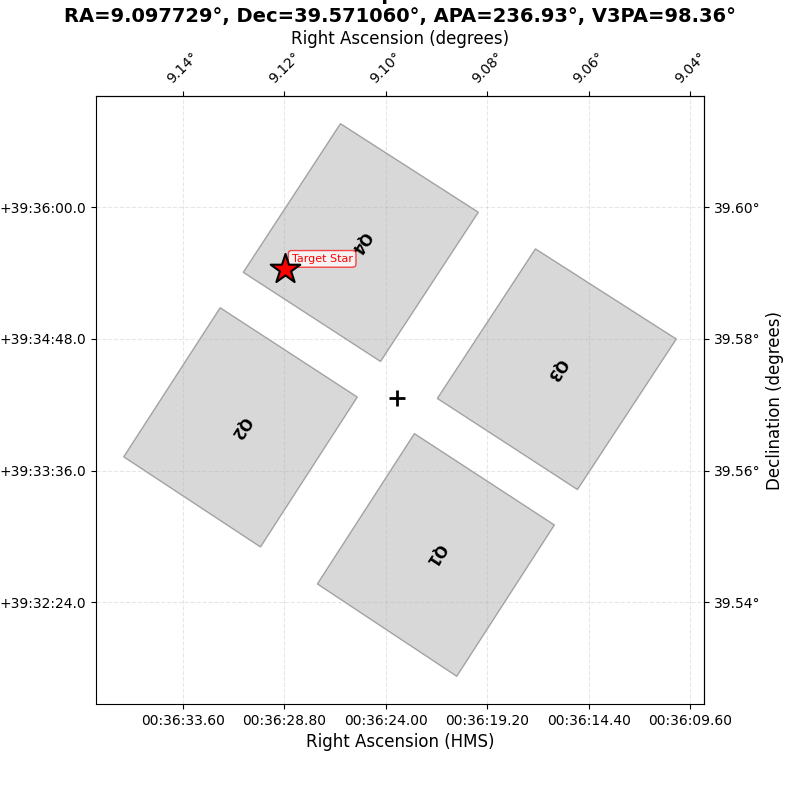


Observation Plot Complete
MSA Pointing:  RA = 00:36:23.45, Dec = +39:34:15.8
APA (Roll):    236.9302°
Target Star:   Q4 at (0.8550, 0.8003)

→ Move your cursor over the plot to see RA/Dec coordinates below


In [16]:
# Plot observation using the plotter's built-in plot_fov method

# Create the plot with semi-transparent quadrant fill (alpha=0.3)
fig, ax = MSA_plotter.plot_fov(
    ra  = msa_ra,
    dec = msa_dec,
    apa = apa,
    aperture_names = 'msa_quadrants',  # Plot only the 4 MSA quadrants
    figsize = (8, 8),
    quadrant_alpha = 0.3,  # Set transparency for quadrant fill (0-1, where 0=transparent, 1=opaque)
    markers = [{'ra': target_ra, 'dec': target_dec, 'color': 'red', 'marker': '*', 'size': 500, 'label': 'Target Star'}]
)

plt.show()

# Setup the coordinate display
setup_coordinate_display(fig, ax)

msa_ra_hms  = Angle(msa_ra, unit='deg').to_string(unit='hourangle', sep=':', precision=2, pad=True)
msa_dec_dms = Angle(msa_dec, unit='deg').to_string(unit='degree',   sep=':', precision=1, pad=True, alwayssign=True)

print(f"\n{'=' * 70}")
print(f"Observation Plot Complete")
print(f"{'=' * 70}")
print(f"MSA Pointing:  RA = {msa_ra_hms}, Dec = {msa_dec_dms}")
print(f"APA (Roll):    {apa:.4f}°")
print(f"Target Star:   Q{quadrant} at ({quad_x_frac:.4f}, {quad_y_frac:.4f})")
print(f"\n→ Move your cursor over the plot to see RA/Dec coordinates below")
print(f"{'=' * 70}")

In [17]:
# Define all 5 observations with their parameters and calculated MSA coordinates
apa = 236.9302
#apa = 0

observations = [
    {
        'id': 1,
        'apa': apa,
        'quadrant': 2,
        'quad_x_frac': 0.835,
        'quad_y_frac': 0.744,
    },
    {
        'id': 2,
        'apa': apa,
        'quadrant': 2,
        'quad_x_frac': 0.5,
        'quad_y_frac': 0.5,
    },
    {
        'id': 3,
        'apa': apa,
        'quadrant': 1,
        'quad_x_frac': 0.1,
        'quad_y_frac': 0.9,
    },
    {
        'id': 4,
        'apa': apa,
        'quadrant': 4,
        'quad_x_frac': 1 - 250 / 365.,  # d250
        'quad_y_frac': 25 / 171.,       # s25
    },
    {
        'id': 5,
        'apa': apa,
        'quadrant': 4,
        'quad_x_frac': 0.8550,
        'quad_y_frac': 0.8003,
    },
]

# Calculate MSA coordinates for each observation
for obs in observations:
    msa_ra, msa_dec = MSA_plotter.sky_to_pointing(
        target_ra, target_dec, 
        obs['apa'], 
        obs['quadrant'], 
        obs['quad_x_frac'], 
        obs['quad_y_frac']
    )
    obs['msa_ra'] = msa_ra
    obs['msa_dec'] = msa_dec

# Display the observations dictionary
print("Observations Dictionary:")
print("=" * 80)
for obs in observations:
    print(f"Observation {obs['id']}:")
    print(f"  APA:          {obs['apa']:.4f}°")
    print(f"  Quadrant:     {obs['quadrant']}")
    print(f"  x_frac:       {obs['quad_x_frac']:.6f}")
    print(f"  y_frac:       {obs['quad_y_frac']:.6f}")
    print(f"  MSA RA:       {obs['msa_ra']:.8f}°")
    print(f"  MSA Dec:      {obs['msa_dec']:.8f}°")
    print()


Observations Dictionary:
Observation 1:
  APA:          236.9302°
  Quadrant:     2
  x_frac:       0.835000
  y_frac:       0.744000
  MSA RA:       9.07591219°
  MSA Dec:      39.59935411°

Observation 2:
  APA:          236.9302°
  Quadrant:     2
  x_frac:       0.500000
  y_frac:       0.500000
  MSA RA:       9.08900920°
  MSA Dec:      39.59510763°

Observation 3:
  APA:          236.9302°
  Quadrant:     1
  x_frac:       0.100000
  y_frac:       0.900000
  MSA RA:       9.12417147°
  MSA Dec:      39.59969839°

Observation 4:
  APA:          236.9302°
  Quadrant:     4
  x_frac:       0.315068
  y_frac:       0.146199
  MSA RA:       9.12587890°
  MSA Dec:      39.56764981°

Observation 5:
  APA:          236.9302°
  Quadrant:     4
  x_frac:       0.855000
  y_frac:       0.800300
  MSA RA:       9.09772889°
  MSA Dec:      39.57106023°



In [18]:
from astropy.coordinates import Angle

print("RA (HMS) for each observation:")
for obs in observations:
    ra_hms = Angle(obs['msa_ra'], unit='degree').to_string(unit='hourangle', sep=':', precision=4)
    #print(f"Observation {obs['id']}: RA = {ra_hms}")
    print(ra_hms)

print("\nDec (DMS) for each observation:")
for obs in observations:
    dec_dms = Angle(obs['msa_dec'], unit='degree').to_string(unit='degree', sep=':', precision=3)
    #print(f"Observation {obs['id']}: Dec = {dec_dms}")
    print(dec_dms)


RA (HMS) for each observation:
0:36:18.2189
0:36:21.3622
0:36:29.8012
0:36:30.2109
0:36:23.4549

Dec (DMS) for each observation:
39:35:57.675
39:35:42.387
39:35:58.914
39:34:03.539
39:34:15.817


## Overlay Multiple Observations

Plot all 5 observations (4, 6, 7, 8, 9) on a single FOV plot with different colors for each observation.
This allows you to see how the MSA orientation changes at different roll angles and how the target position varies within the MSA.

### Quadrant Fill with Transparency

The `plot_multiple_fov()` method now supports the `quadrant_alpha` parameter to add semi-transparent fills to the MSA quadrants:
- Use `quadrant_alpha=0.2` for light fills
- Use `quadrant_alpha=0.5` for medium fills  
- Use `quadrant_alpha=0.8` for dark fills
- Use `quadrant_alpha=None` or omit the parameter for no fills (original behavior)

This makes it easier to distinguish between different observations when overlaying multiple FOVs.


Observations to overlay:
Observation  1: RA=9.07591219°, Dec=39.59935411°, APA=236.9302°)
Observation  2: RA=9.08900920°, Dec=39.59510763°, APA=236.9302°)
Observation  3: RA=9.12417147°, Dec=39.59969839°, APA=236.9302°)
Observation  4: RA=9.12587890°, Dec=39.56764981°, APA=236.9302°)
Observation  5: RA=9.09772889°, Dec=39.57106023°, APA=236.9302°)


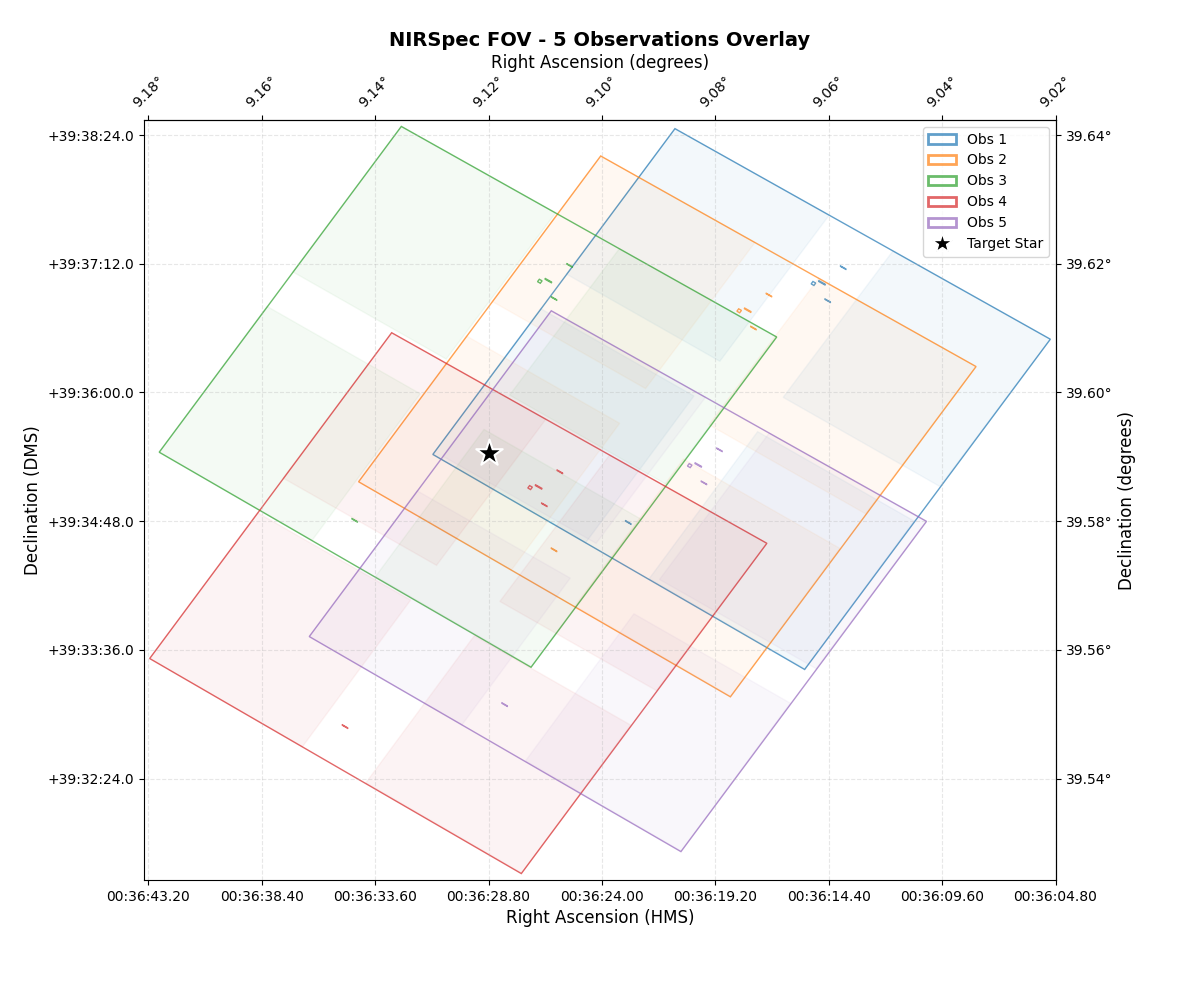

In [19]:
# Create observation list for overlay plot
# Use observations 4, 6, 7, 8, and 9
observations_to_overlay = [obs for obs in observations if True] # obs['id'] in [4, 6, 8, 9, 10]]

print("Observations to overlay:")
print("=" * 70)
for obs in observations_to_overlay:
    print(f"Observation {obs['id']:2d}: RA={obs['msa_ra']:.8f}°, Dec={obs['msa_dec']:.8f}°, "
          f"APA={obs['apa']:.4f}°)") # , Color={obs['color']}, Type={obs['type']}")

# Plot all observations on a single plot with different colors
fig, ax = MSA_plotter.plot_multiple_fov(
    observations=observations_to_overlay,
    aperture_names='default',
    figsize=(12, 10),
    title='NIRSpec FOV - 5 Observations Overlay',
    #title='NIRSpec FOV - 5 Observations Overlay\n(Different Colors for Different Roll Angles)',
    show_labels=True,
    target_ra=target_ra,
    target_dec=target_dec,
    interactive=True,
    quadrant_alpha=0.05  # Semi-transparent fills
)

plt.show()

## Test: Fixed Grid with Multiple Observations

Now let's test the new `plot_fixed_grid_with_observations()` function. This plots a single MSA grid at APA=0 and shows where the target appears for all 5 observations.

In [20]:
# Reload the module to get the new function
if 'nirspec_fov_plotter' in sys.modules: 
    del sys.modules['nirspec_fov_plotter']
from nirspec_fov_plotter import NIRSpecFOVPlotter

# Create a new plotter instance
plotter = NIRSpecFOVPlotter()
print("NIRSpecFOVPlotter reloaded with new plot_fixed_grid_with_observations() function")

NIRSpecFOVPlotter reloaded with new plot_fixed_grid_with_observations() function


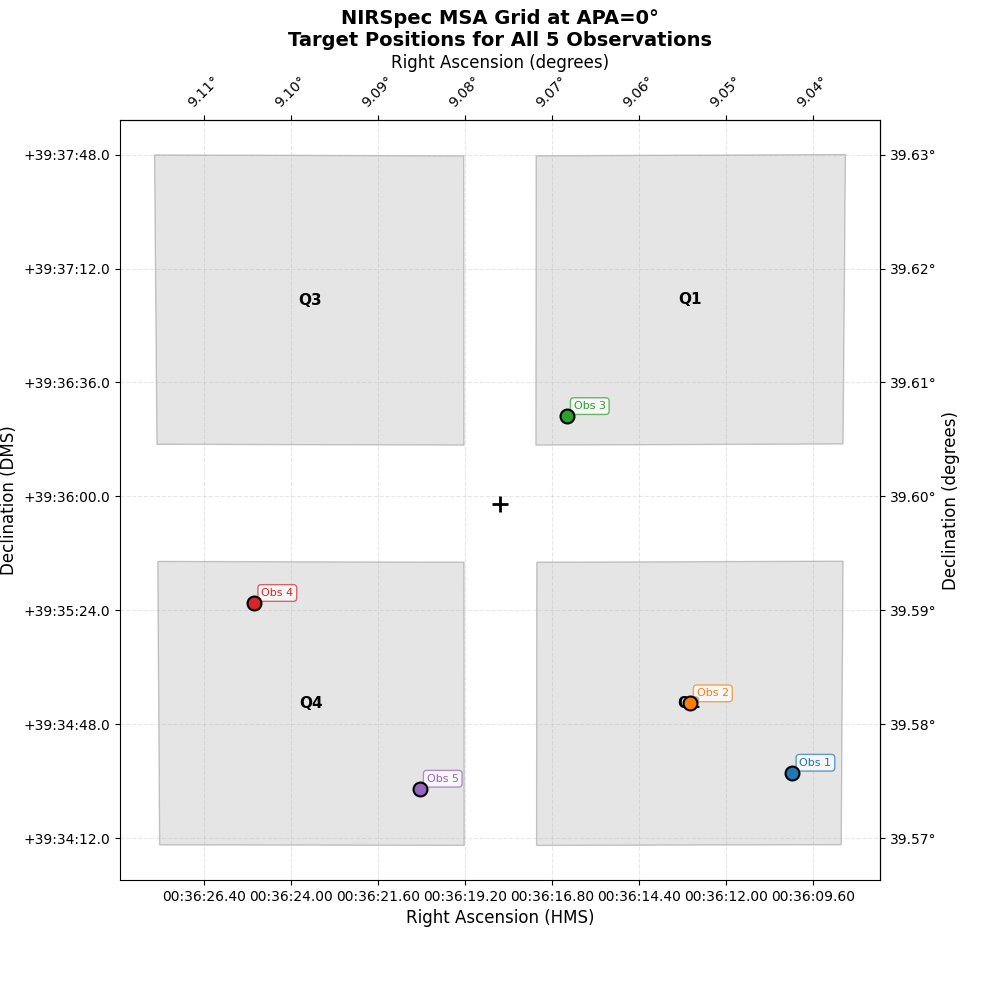


Fixed Grid Plot Complete
Grid APA: 0.0° (upright orientation)
Number of observations plotted: 5

Each colored marker shows where the target appears on this fixed grid
for each of the 5 observations with different MSA pointings.

→ Move your cursor over the plot to see RA/Dec coordinates


In [21]:
# Plot the fixed grid at APA=0 with all 5 observations
# The grid will use the first observation's MSA pointing as reference
fig, ax = MSA_plotter.plot_fixed_grid_with_observations(
    observations=observations,
    grid_apa=0.0,  # Fixed grid at APA=0 (upright orientation)
    aperture_names='msa_quadrants',
    figsize=(10, 10),
    title='NIRSpec MSA Grid at APA=0°\nTarget Positions for All 5 Observations',
    show_labels=True,
    interactive=True,
    quadrant_alpha=0.2  # Light transparent fill
)

plt.show()

# Setup coordinate display
setup_coordinate_display(fig, ax)

print(f"\n{'=' * 70}")
print(f"Fixed Grid Plot Complete")
print(f"{'=' * 70}")
print(f"Grid APA: 0.0° (upright orientation)")
print(f"Number of observations plotted: {len(observations)}")
print(f"\nEach colored marker shows where the target appears on this fixed grid")
print(f"for each of the 5 observations with different MSA pointings.")
print(f"\n→ Move your cursor over the plot to see RA/Dec coordinates")
print(f"{'=' * 70}")

### Understanding the Plot

The plot above shows a **single fixed MSA grid at APA=0** (upright orientation). The colored markers show where the actual target star appears on this grid for each of the 5 observations.

**Key Points:**
- The grid itself is fixed at APA=0° using the first observation's MSA pointing as reference
- Each observation had a different MSA pointing (RA, Dec) to place the target at a specific quadrant position
- The function calculates the actual sky coordinates of the target for each observation
- All 5 target positions are plotted on this single fixed grid

**Expected Result:**
Since each observation places the target at different fractional positions within different quadrants, we should see the markers distributed across the grid:
- **Obs 1** (red): Q2 at (0.835, 0.744) - near bottom-right of Q2
- **Obs 2** (blue): Q2 at (0.5, 0.5) - center of Q2
- **Obs 3** (green): Q1 at (0.1, 0.9) - near top-left of Q1  
- **Obs 4** (orange): Q4 at specific field point
- **Obs 5** (purple): Q4 at (0.855, 0.800) - lower-right region of Q4

This demonstrates that the same target can be observed at different positions in the MSA by adjusting the telescope pointing!

In [22]:
# Verify: Print the calculated target positions for each observation
print("Calculated Target Positions on Fixed Grid (APA=0):")
print("=" * 80)

# Use the first observation's MSA pointing as the grid reference
grid_ra = observations[0]['msa_ra']
grid_dec = observations[0]['msa_dec']

print(f"Grid Reference: RA={grid_ra:.6f}°, Dec={grid_dec:.6f}°\n")

for obs in observations:
    # Calculate target position for this observation
    target_ra_calc, target_dec_calc = MSA_plotter.quadrant_position_to_sky(
        grid_ra, grid_dec,
        quadrant=obs['quadrant'],
        quad_x_frac=obs['quad_x_frac'],
        quad_y_frac=obs['quad_y_frac']
    )
    
    # Convert to HMS/DMS for readability
    target_ra_hms = Angle(target_ra_calc, unit='degree').to_string(unit='hourangle', sep=':', precision=2)
    target_dec_dms = Angle(target_dec_calc, unit='degree').to_string(unit='degree', sep=':', precision=1)
    
    print(f"Obs {obs['id']}: Q{obs['quadrant']} ({obs['quad_x_frac']:.3f}, {obs['quad_y_frac']:.3f})")
    print(f"  → Target at: {target_ra_hms} / {target_dec_dms}")
    print(f"              ({target_ra_calc:.6f}°, {target_dec_calc:.6f}°)")
    print()

Calculated Target Positions on Fixed Grid (APA=0):
Grid Reference: RA=9.075912°, Dec=39.599354°

Obs 1: Q2 (0.835, 0.744)
  → Target at: 0:36:10.17 / 39:34:32.7
              (9.042359°, 39.575746°)

Obs 2: Q2 (0.500, 0.500)
  → Target at: 0:36:13.00 / 39:34:54.6
              (9.054154°, 39.581834°)

Obs 3: Q1 (0.100, 0.900)
  → Target at: 0:36:16.39 / 39:36:25.4
              (9.068281°, 39.607051°)

Obs 4: Q4 (0.315, 0.146)
  → Target at: 0:36:25.00 / 39:35:26.3
              (9.104181°, 39.590646°)

Obs 5: Q4 (0.855, 0.800)
  → Target at: 0:36:20.44 / 39:34:27.6
              (9.085173°, 39.574342°)



## Summary

The new `plot_fixed_grid_with_observations()` function successfully:

1. ✅ Creates a single fixed MSA grid at a specified pointing and APA (default APA=0)
2. ✅ Calculates the actual sky coordinates of the target for each observation based on:
   - The observation's quadrant position (quadrant, quad_x_frac, quad_y_frac)
   - The fixed grid's pointing (RA, Dec)
3. ✅ Plots all target positions as colored markers on the single grid
4. ✅ Shows how the same astronomical target appears at different positions in the MSA depending on the telescope pointing

**Key Insight:** This visualization demonstrates that by adjusting the telescope's MSA pointing, the same target can be placed at any desired position within the MSA field of view. The 5 different colored markers show the target at different quadrant positions, all on a single upright (APA=0) grid.